In [58]:
# !pip install shapely
# !pip install scikit-learn==1.5.0


In [59]:
import json
import itertools
import pandas as pd
from lib import *
from scipy.stats import gaussian_kde
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap

model_path = '../modeling/2d/'
data_path = './data/formatted/liver.csv'
ris_path = './data/leeds_ris.json'
gender = 'M'

# create analyzer
analyzer = ReferenceRegionAnalyzer(model_path, ris_path)


In [60]:
# load dataset
df = pd.read_csv(data_path, index_col=0)
analytes = df.columns[3:] # list of analytes
ris_dict = json.load(open(ris_path, 'r')) # ris
log_analytes = list(analytes) # transform all analytes


In [61]:
print('No. data points: '+str(df.shape[0]))


No. data points: 612


In [62]:
def create_modified_colormap(cmap_name, gamma=0.5):
    original_cmap = mpl.colormaps[cmap_name]  # Get the original colormap
    # create a lambda function that applies the gamma correction
    gamma_correction = lambda x: x ** gamma
    # create the new colormap by applying the gamma correction
    new_cmap = LinearSegmentedColormap.from_list(
        f'{cmap_name}_modified',
        original_cmap(gamma_correction(np.linspace(0, 1, 256)))
    )
    return new_cmap
modified_cmap = create_modified_colormap('Blues', gamma=0.75)

analyte_dict = { # analyte abbreviations
    'alanine aminotransferase': 'ALT',
    'albumin': 'ALB',
    'alkaline phosphatase': 'ALK',
    'aspartate aminotransferase': 'AST',
    'globulin': 'GLOB',
    'platelets': 'PLT',
    'bilirubin': 'BIL',
    'creatinine': 'CREA',
    'gamma-glutamyl transferase': 'GGT', 
    'total protein': 'PROT'
}

if gender=='F':
    # females
    ticks = { # manually define tick positions
        'alanine aminotransferase': [0, 0, 20, 40, 60, 60], # last elements are limits
        'albumin': [2.5, 2.5, 3.5, 4.5, 5.5, 6],
        'alkaline phosphatase': [0, 0, 40, 80, 120, 140],
        'aspartate aminotransferase': [0, 0, 20, 40, 60, 80, 80],
        'bilirubin': [0, 0, 0.5, 1.0, 1.5, 1.5],
        'creatinine': [0.4, 0.4, 0.8, 1.2, 1.2],
        'gamma-glutamyl transferase': [0, 0, 20, 40, 60, 80, 90],
        'total protein': [5.5, 5.5, 6.5, 7.5, 8.5, 8.5]
    }
elif gender=='M':
    # males
    ticks = { # manually define tick positions
        'alanine aminotransferase': [0, 0, 30, 60, 90, 100], # last elements are limits
        'albumin': [2.5, 2.5, 3.5, 4.5, 5.5, 6],
        'alkaline phosphatase': [0, 0, 40, 80, 120, 140],
        'aspartate aminotransferase': [0, 0, 20, 40, 60, 80, 80],
        'bilirubin': [0, 0, 0.5, 1.0, 1.5, 2.0, 2.0],
        'creatinine': [0.4, 0.4, 0.8, 1.2, 1.6, 1.6],
        'gamma-glutamyl transferase': [0, 0, 40, 80, 120, 130],
        'total protein': [5.5, 5.5, 7.5, 9.5, 9.5]
    }


In [63]:
labelpad = -1
labelfs = 12
subplotspacing = 0.4
plot_path_points = True
path_cmap = mpl.colormaps['Reds']


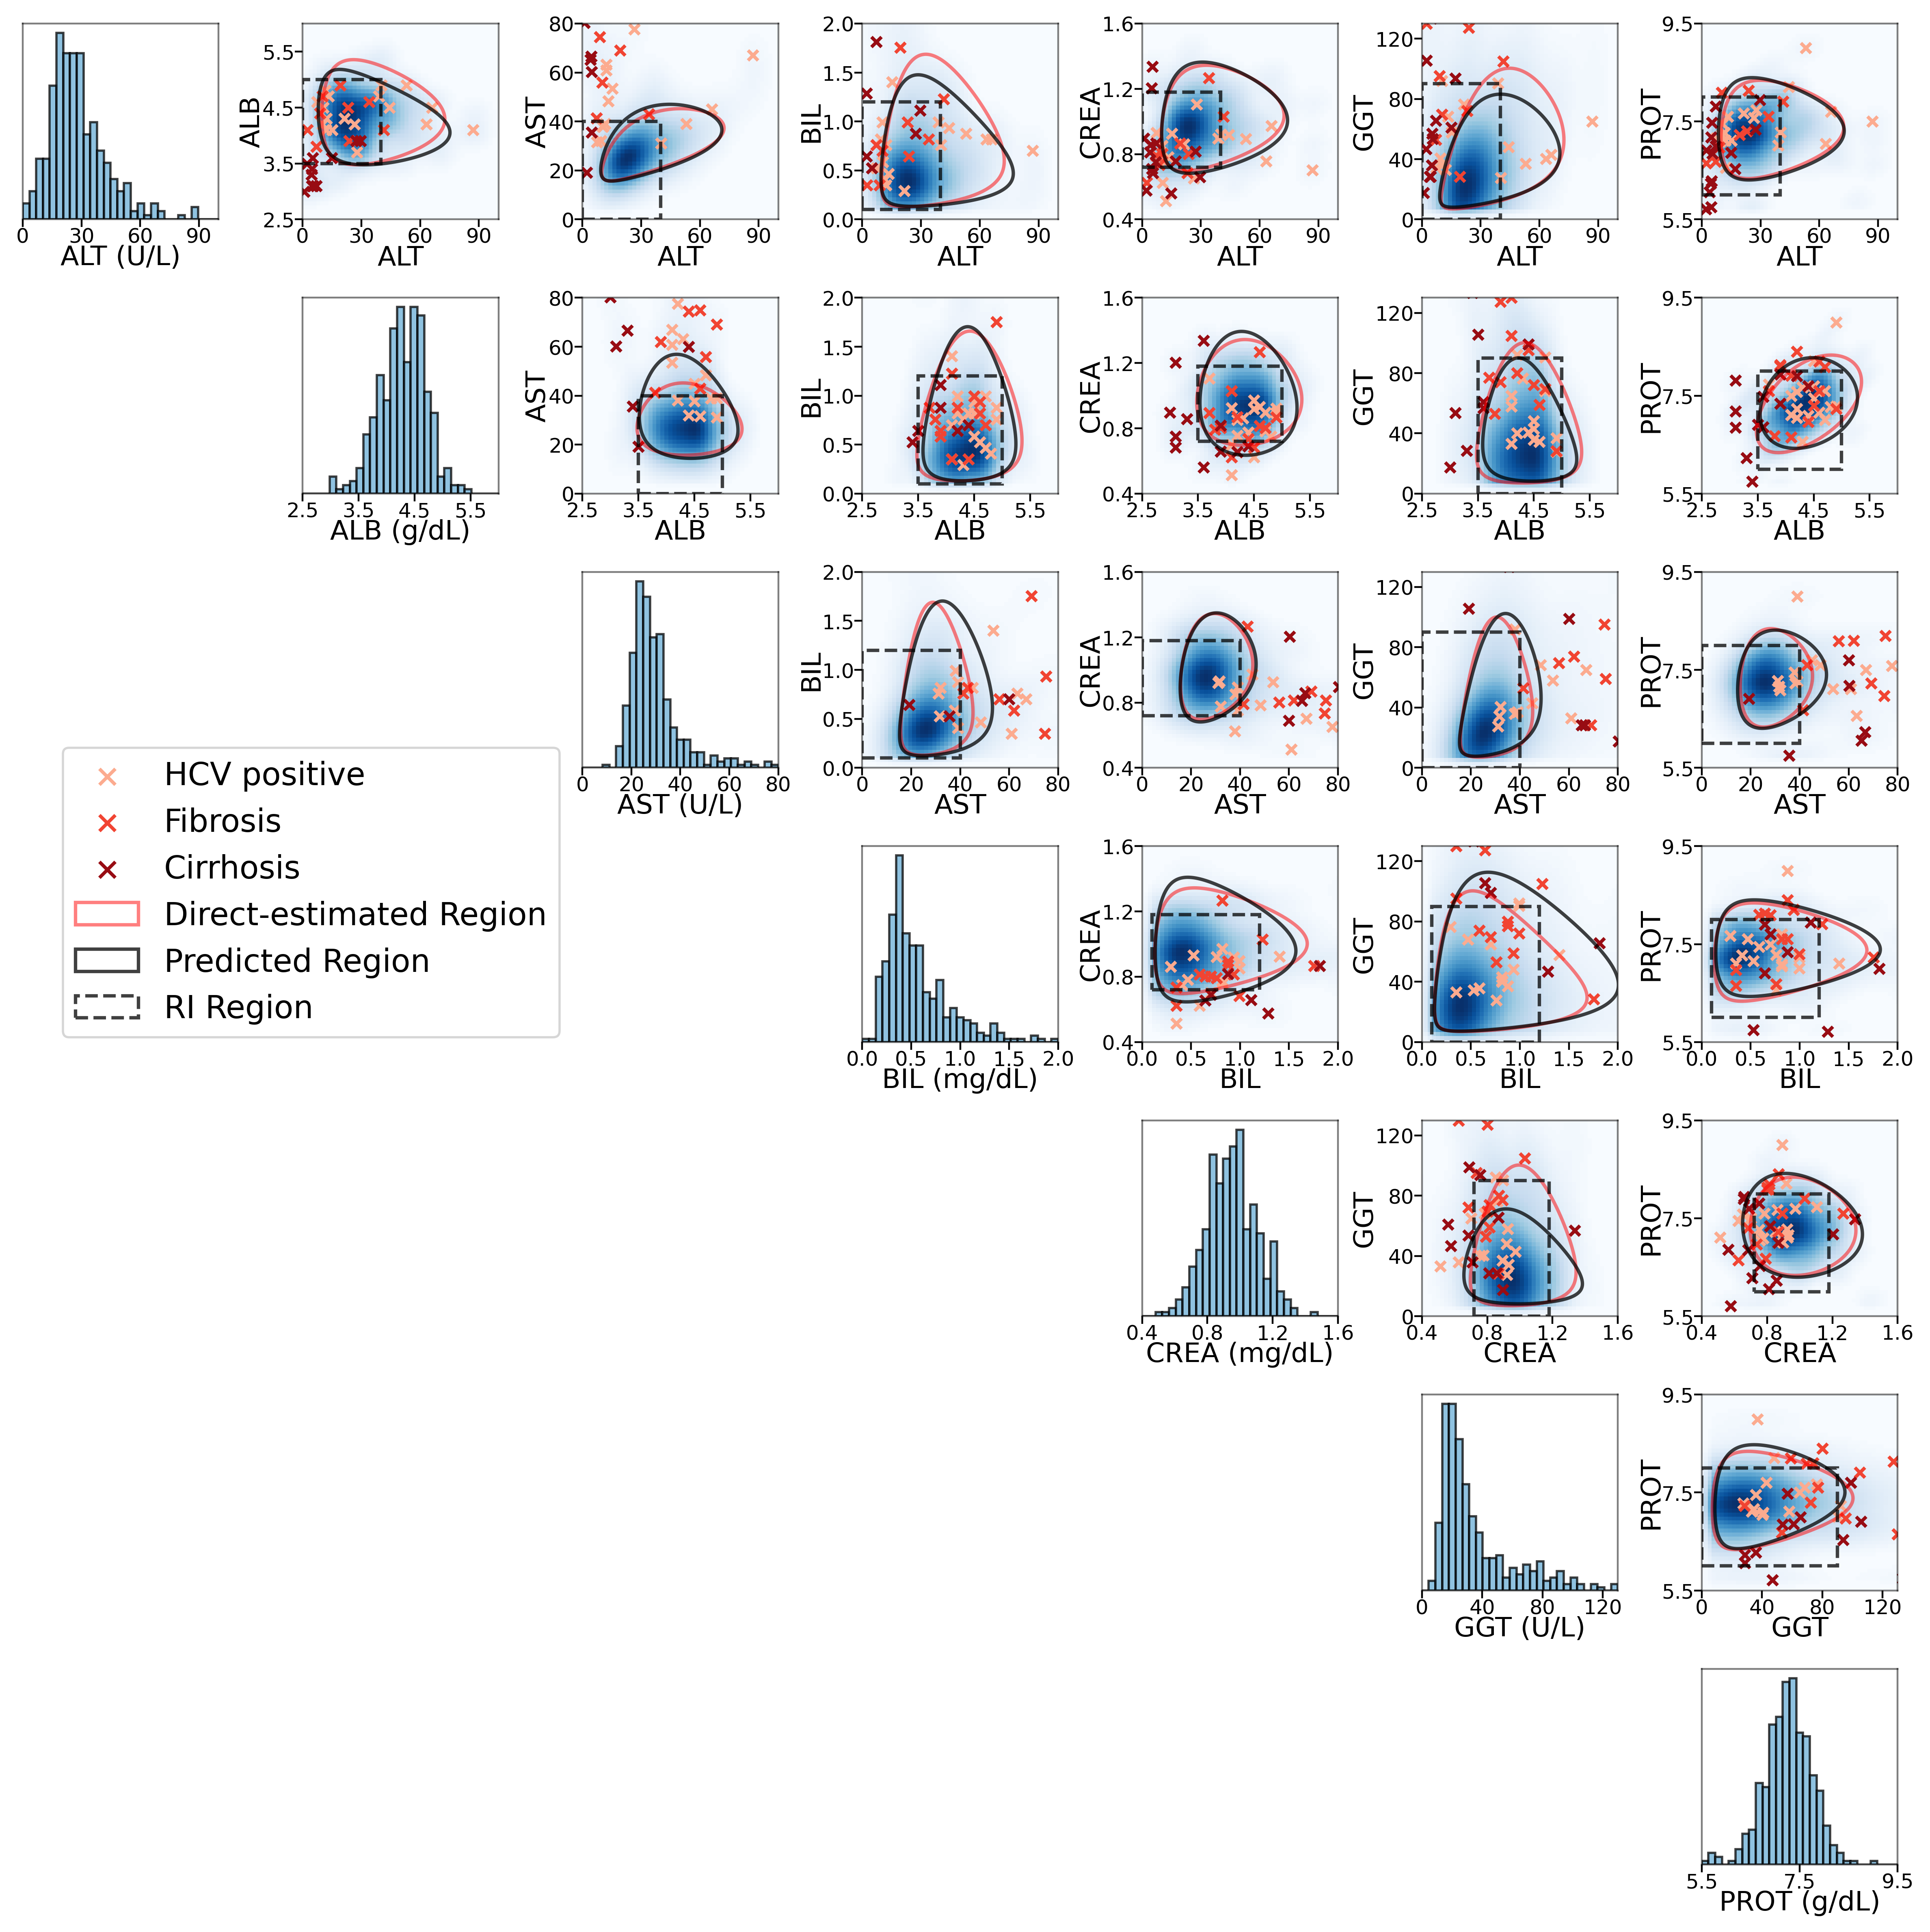

In [64]:
plt.figure(figsize=(12, 12), dpi=400)

ncols = len(analytes)
n = 0
for i in range(ncols):
    for j in range(ncols):
                
        n+=1
        
        # don't repeat anss
        if j<i:
            continue
            
#         # for testing
#         if i>0:
#             break
            
        if i==j:
            ans = [analytes[i]]
        else:
            ans = [analytes[i], analytes[j]]
        
        if i!=j: # if bivariate data
            
            # model prediction
            data, labels = get_data(df, ans, gender, log_analytes)
            region_p, gaus_p = analyzer.get_region(data)

            # direct prediction
            data, labels = get_data(df[df.label=='reference'], ans, gender, log_analytes) # preprocessing on healthy subset
            gaus_y = {
                'mean': data.mean(axis=0),
                'covariance': np.cov(data.T)
            }            
            region_y = get_ellipse_vertices(plot_cov_ellipse(gaus_y['mean'], gaus_y['covariance']))

            # get established RIs
            region_ri = get_ri_vertices(ris_dict, ans, gender)
            
            # inverse transform regions
            for c in range(2):
                if ans[c] in log_analytes:
                    region_p[:,c] = np.exp(region_p[:,c])
                    region_y[:,c] = np.exp(region_y[:,c])
            
        # get full dataset not transformed
        # outlier removal?
        data, labels = get_data(df, ans, gender, log_analytes, 
                                   outlier_removal = True,
                                   transform = False)

        # plot
        
        plt.subplot(ncols, ncols, n)
        
        # define plot boundaries
        x_range = [ticks[ans[0]][0], ticks[ans[0]][-1]]
        if i!=j:
            y_range = [ticks[ans[1]][0], ticks[ans[1]][-1]]
                
        if i==j: # histogram
            bins = np.linspace(x_range[0], x_range[1], 30)
            plt.hist(data, bins, edgecolor='k', alpha=0.75, color=mpl.colormaps['Blues'](0.5))
            plt.xlim(x_range)
            plt.xticks(ticks[ans[0]][1:-1])
            plt.yticks([])
            
        else: # KDE            

            # KDE
            kde = gaussian_kde(data.T)
            x_grid, y_grid = np.meshgrid(
                np.linspace(x_range[0], x_range[1], 50), 
                np.linspace(y_range[0], y_range[1], 50)
            )
            positions = np.vstack([x_grid.ravel(), y_grid.ravel()]).T
            pdf = kde(positions.T).reshape(x_grid.shape)
            for an in ['gamma-glutamyl transferase', 'bilirubin']:
                if ans[0]==an:
                    pdf[:,0:3] *= np.array([[0.1, 0.3, 0.6]])
                else:
                    pdf[0:3,:] *= np.array([[0.1, 0.3, 0.6]]).T          
            plt.pcolormesh(x_grid, y_grid, pdf, cmap=modified_cmap) 
            
            if plot_path_points:
#                 plt.scatter(data[~labels,0], data[~labels,1], s=20, alpha=0.25, marker='o', color='dodgerblue', label='Blood donor')
                plt.scatter(data[labels=='hepatitis',0], data[labels=='hepatitis',1], s=20, alpha=1, marker='x', color=path_cmap(0.3), label='HCV positive')
                plt.scatter(data[labels=='fibrosis',0], data[labels=='fibrosis',1], s=20, alpha=1, marker='x', color=path_cmap(0.6), label='Fibrosis')
                plt.scatter(data[labels=='cirrhosis',0], data[labels=='cirrhosis',1], s=20, alpha=1, marker='x', color=path_cmap(0.9), label='Cirrhosis')

            # plot regions
            polygon = plt.Polygon(
                region_y, 
                closed=True, fill=None, edgecolor='r', linewidth=1.5, zorder=10, alpha=0.5,
                label='Direct-estimated Region'
            )
            plt.gca().add_patch(polygon)
            
            polygon = plt.Polygon(
                region_p, 
                closed=True, fill=None, edgecolor='k', linewidth=1.5, zorder=10, alpha=0.75,
                label='Predicted Region'
            )
            plt.gca().add_patch(polygon)    
            
            polygon = plt.Polygon( # RI
                region_ri, 
                closed=True, fill=None, edgecolor='k', linestyle='--', linewidth=1.5, zorder=10, alpha=0.75,
                label='RI Region'
            )
            plt.gca().add_patch(polygon)
            
            # formatting
            plt.xticks(ticks[ans[0]][1:-1])
            plt.yticks(ticks[ans[1]][1:-1])
            plt.xlim(x_range)
            plt.ylim(y_range)
                
        # formatting
        plt.gca().set_box_aspect(1)
        plt.gca().tick_params(axis='both', labelsize=9, pad=0)
        if i==j:
            plt.xlabel(analyte_dict[ans[0]]+' ('+analyzer.ris[ans[0]]['unit']+')', labelpad=labelpad, fontsize=labelfs)            
        else:
            plt.xlabel(analyte_dict[ans[0]], labelpad=labelpad, fontsize=labelfs)
            plt.ylabel(analyte_dict[ans[1]], labelpad=labelpad, fontsize=labelfs)
        for spine in plt.gca().spines.values():
            spine.set_alpha(0.5)
        
        if n==2:
            handles, labels = plt.gca().get_legend_handles_labels()
            lgnd = plt.gcf().legend(handles, labels, bbox_to_anchor=(0.30,0.62), fontsize=14)
            if plot_path_points:
                for handle in lgnd.legend_handles[:3]:
                    handle.set_sizes([50])
                
#         # checking
#         plt.title(round(result['model']['iou'], 2))
        
plt.tight_layout()
plt.subplots_adjust(wspace=subplotspacing, hspace=subplotspacing)

    